In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

file = 'data_set_ALL_AML_train.csv'
data = pd.read_csv(file, index_col=1)

In [2]:
# Print info and shape of DataFrame
print(data.info())
print(data.shape)

# Remove 'call' columns from DataFrame
a = ['call'] + ['call.' + str(x) for x in range(1,38)]
data = data.drop(columns=a)

# Remove microarray controls (indicated by 'AFFX') from DataFrame rows
controls = []
for entry in data.index:
    if 'AFFX' in entry:
        controls.append(entry)
controls.append('hum_alu_at')
data = data.drop(labels=controls, axis=0)

print(data.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 7129 entries, AFFX-BioB-5_at to Z78285_f_at
Data columns (total 77 columns):
Gene Description    7129 non-null object
1                   7129 non-null int64
call                7129 non-null object
2                   7129 non-null int64
call.1              7129 non-null object
3                   7129 non-null int64
call.2              7129 non-null object
4                   7129 non-null int64
call.3              7129 non-null object
5                   7129 non-null int64
call.4              7129 non-null object
6                   7129 non-null int64
call.5              7129 non-null object
7                   7129 non-null int64
call.6              7129 non-null object
8                   7129 non-null int64
call.7              7129 non-null object
9                   7129 non-null int64
call.8              7129 non-null object
10                  7129 non-null int64
call.9              7129 non-null object
11                  7129 no

In [19]:
key = pd.read_csv('actual.csv', index_col=0)
print(key.head(38))

        cancer
patient       
1          ALL
2          ALL
3          ALL
4          ALL
5          ALL
6          ALL
7          ALL
8          ALL
9          ALL
10         ALL
11         ALL
12         ALL
13         ALL
14         ALL
15         ALL
16         ALL
17         ALL
18         ALL
19         ALL
20         ALL
21         ALL
22         ALL
23         ALL
24         ALL
25         ALL
26         ALL
27         ALL
28         AML
29         AML
30         AML
31         AML
32         AML
33         AML
34         AML
35         AML
36         AML
37         AML
38         AML


I want to merge the gene expression dataframe ('data') with the key to create a dataframe that includes information on the type of cancer. I can then groupby the 'cancer' column to perform aggregations such as determining the mean and standard deviation of the expression level for each gene in the dataset.

In order to merge the 'data' and 'key' dataframes, however, I first need to reshape the data.

In [4]:
# Transpose rows and columns so that each column is a different gene
transposed_data = data.transpose()

# Drop the 'Gene Description' row as it is not useful here
cleaned_data = transposed_data.drop(['Gene Description'])
cleaned_data.index = cleaned_data.index.map(int)
print(cleaned_data.info())

# Convert columns to numeric datatypes instead of objects
cleaned_data = cleaned_data.apply(pd.to_numeric, errors='coerce')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 1 to 33
Columns: 7070 entries, A28102_at to Z78285_f_at
dtypes: object(7070)
memory usage: 2.1+ MB
None


In [5]:
# Merge the key dataframe with the trimmed dataframe to assign the cancer type to each patient sample
exp_data = pd.concat([key, cleaned_data], axis=1, join='inner')

# Check that output has the expected shape
print(exp_data.shape)

# Group by cancer type to aggregate and calculate useful statistical information with describe()
stats = exp_data.groupby('cancer').agg(['mean', 'std'])
print(stats)

(38, 7071)
         A28102_at             AB000114_at            AB000115_at              \
              mean         std        mean        std        mean         std   
cancer                                                                          
ALL     258.555556  203.127723   40.296296  57.974673  311.851852  464.190006   
AML     316.090909  126.132830    6.090909  31.007917  319.090909  344.798624   

       AB000220_at            AB000409_at              ...    X83863_at  \
              mean        std        mean         std  ...         mean   
cancer                                                 ...                
ALL      34.962963  31.709598    4.592593  170.532257  ...   769.222222   
AML      41.000000  62.689712   33.454545  231.140375  ...  1114.090909   

                     Z17240_at             L49218_f_at             \
               std        mean         std        mean        std   
cancer                                                              


In [6]:
# Transpose dataframe so that genes form the rows
df = stats.transpose()
print(df.head(8))
print(df.shape)
print(df.info())

cancer                   ALL         AML
A28102_at   mean  258.555556  316.090909
            std   203.127723  126.132830
AB000114_at mean   40.296296    6.090909
            std    57.974673   31.007917
AB000115_at mean  311.851852  319.090909
            std   464.190006  344.798624
AB000220_at mean   34.962963   41.000000
            std    31.709598   62.689712
(14140, 2)
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 14140 entries, (A28102_at, mean) to (Z78285_f_at, std)
Data columns (total 2 columns):
ALL    14140 non-null float64
AML    14140 non-null float64
dtypes: float64(2)
memory usage: 637.6+ KB
None


cancer              ALL         AML
A28102_at    258.555556  316.090909
AB000114_at   40.296296    6.090909
AB000115_at  311.851852  319.090909
AB000220_at   34.962963   41.000000
AB000409_at    4.592593   33.454545
(7070, 2)
cancer                   ALL  AML
D78333_at           7.962963  0.0
HG3748-HT4018_at  194.740741  0.0
cancer            ALL        AML
HG4051-HT4321_at  0.0 -17.454545
HG4679-HT5104_at  0.0  -9.636364


C:\Users\Caitlin\Miniconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


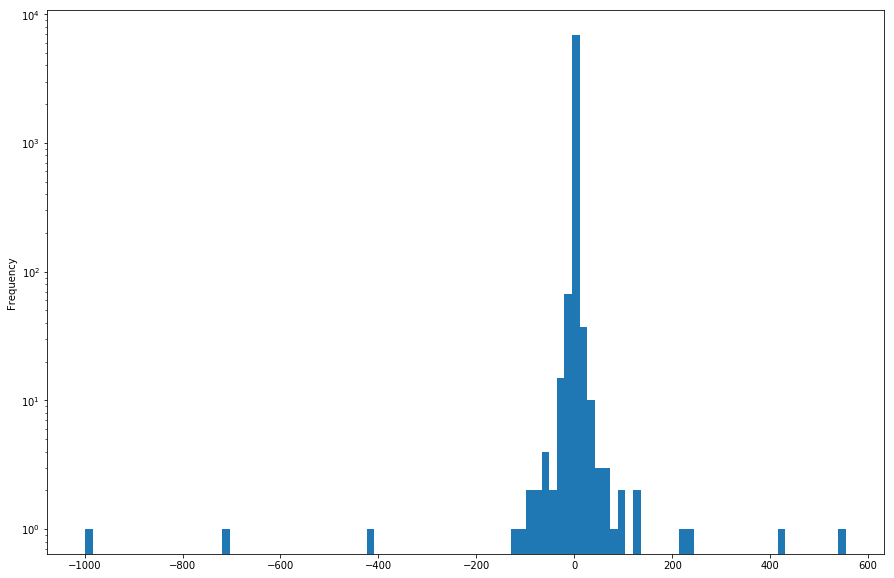

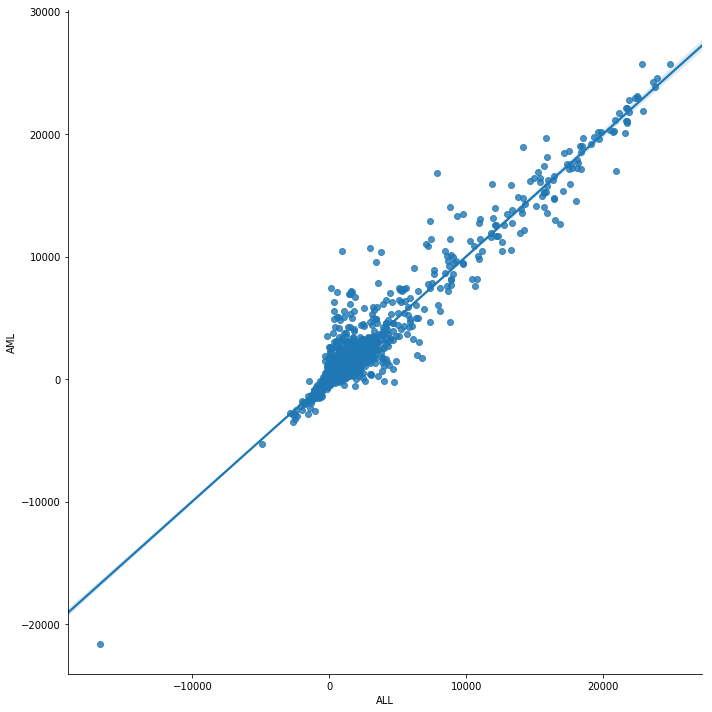

In [7]:
# Slice out just the means from the dataframe
means = df.loc[(slice(None), 'mean'), :]

# Reset the index and drop 'mean' column from dataframe
means.reset_index(level=1, inplace=True)
means.drop(columns='level_1', inplace=True)
print(means.head())
print(means.shape)

# Identify data where either ALL or AML mean is 0 and print to inspect data
AML_zero = means[means.AML == 0]
print(AML_zero)
ALL_zero = means[means.ALL == 0]
print(ALL_zero)

# Drop rows where either ALL or AML is zero from the dataframe
means = means[(means.ALL != 0) & (means.AML != 0)]

# Calculate the ratio of ALL mean to AML mean for all nonzero data
means.loc[:, 'Ratio'] = means['ALL'] / means['AML']
# Plot histogram of the ALL/AML mean ratios
means['Ratio'].plot(kind='hist', bins=100, logy=True, figsize=(15,10))

sns.lmplot(x='ALL', y='AML', data=means, height=10)
plt.show()

In [8]:
# Examine outlier from linear regression plot where ALL mean is < -10000
print(means[means.ALL < -10000])
print(df.loc['HG2887-HT3031_at'])
print(data.loc['HG2887-HT3031_at'])
# The ratio of ALL:AML means suggests that this gene is expressed similarly in both cancers, 
# so it can be excluded from further analysis
means = means[means.ALL > -10000]

cancer                     ALL           AML     Ratio
HG2887-HT3031_at -16775.407407 -21587.818182  0.777077
cancer           ALL           AML
mean   -16775.407407 -21587.818182
std      5581.288818   5939.622594
Gene Description    Sry-Related Hmg-Box 12 Protein (Gb:X73039)
1                                                       -19826
2                                                       -17930
3                                                       -27182
4                                                       -23396
5                                                       -10339
6                                                       -21658
7                                                       -24024
8                                                       -27570
9                                                       -25171
10                                                      -12500
11                                                      -17480
12                           

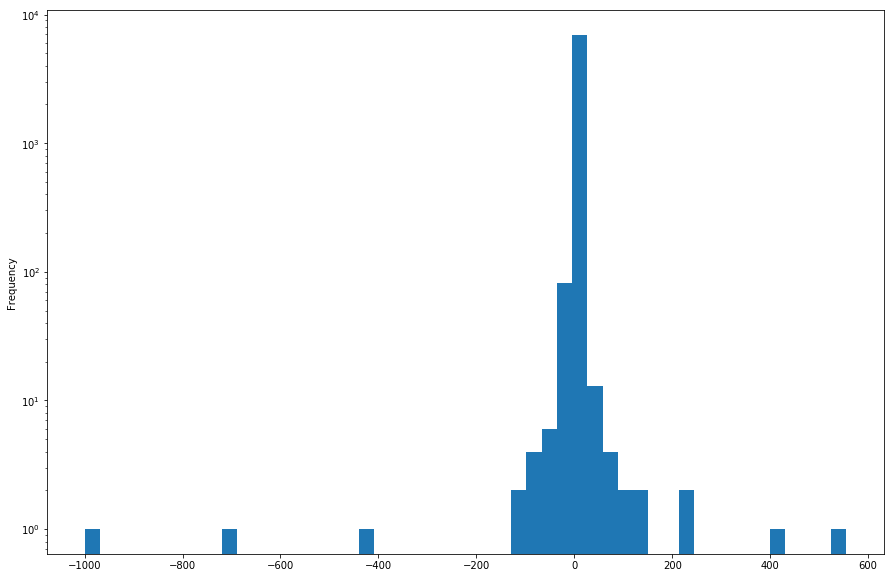

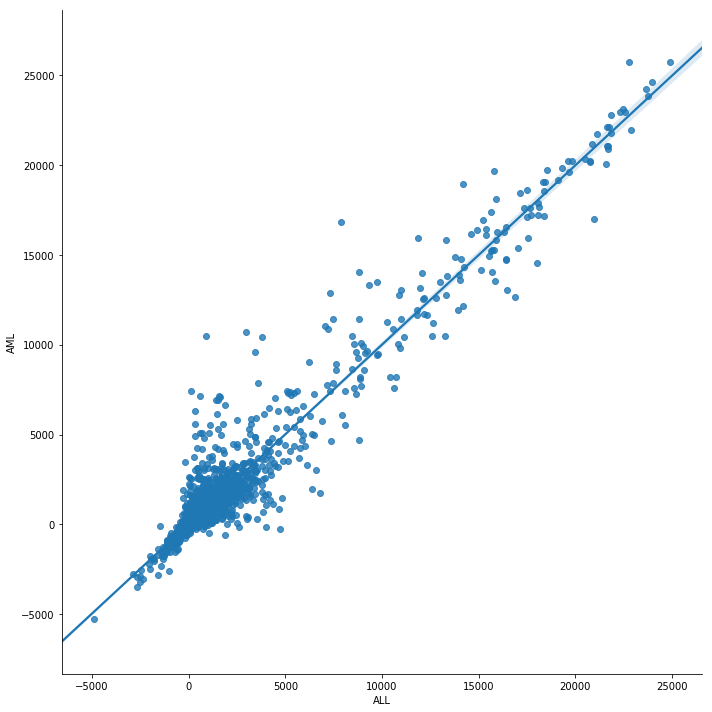

In [9]:
# Re-plot histogram and linear regression of ratios
means['Ratio'].plot(kind='hist', bins=50, logy=True, figsize=(15,10))
sns.lmplot(x='ALL', y='AML', data=means, height=10)
plt.show()

(7065, 3)
(1694, 3)
(257, 3)
(5, 3)
cancer              ALL       AML       Ratio
M54992_at    531.518519 -1.272727 -417.621693
U50929_at    -39.037037 -0.090909  429.407407
U79285_at    302.703704  0.545455  554.956790
U91985_at    181.629630 -0.181818 -998.962963
U46006_s_at  257.074074 -0.363636 -706.953704
cancer             ALL         AML     Ratio
AC000066_at  -1.555556  -18.909091  0.082265
AF000430_at  -0.703704   16.818182 -0.041842
AF005361_at   0.888889  -23.000000 -0.038647
D10495_at    34.000000  712.454545  0.047722
D10923_at     6.222222  185.272727  0.033584


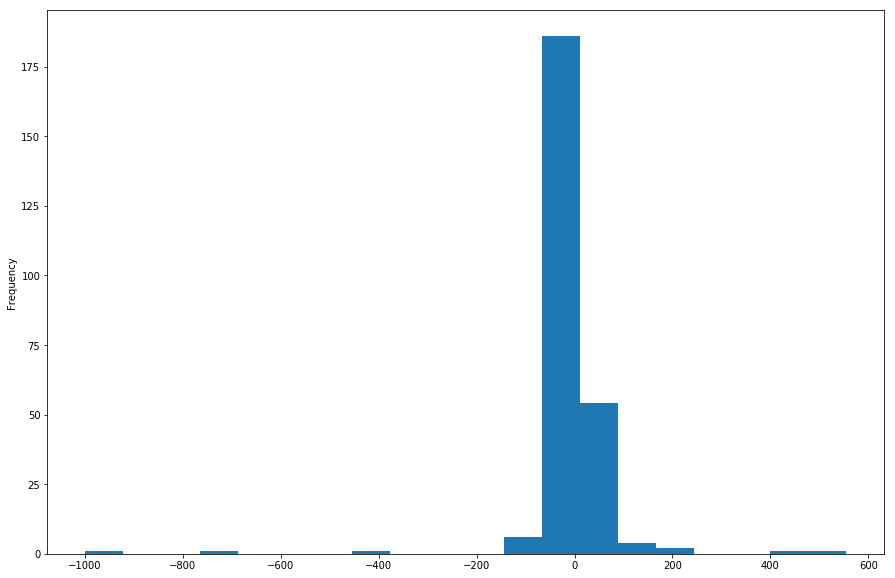

In [10]:
print(means.shape)
# Shows that there are 7066 genes currently in the data set

# Filter out all data where ALL/AML mean ratio is between 0.5 to 2 - a two-fold or more difference
low_ratios = means[(abs(means.Ratio) <= 0.5) | (abs(means.Ratio) >= 2)]
print(low_ratios.shape)
# There are now 1694 genes remaining in the data set - still too many genes

# Select data where there is a 10-fold difference between AML and ALL means, i.e. ratio is less than 0.1 or more than 10
high_ratios = means[(abs(means.Ratio) <= 0.1) | (abs(means.Ratio) >= 10)]
print(high_ratios.shape)
# Plot distribution of high_ratios
high_ratios['Ratio'].plot(kind='hist', bins=20, figsize=(15,10))

# Examine data with ratios > 300 or < -300
outlier_ratios = means[abs(means.Ratio) > 300]
print(outlier_ratios.shape)
print(outlier_ratios)
print(high_ratios.head())

Based on what I have seen of the data thus far, I also need to filter by overall expression level and not just the ALL/AML mean ratio, as genes with very low expression levels can have very large ratios.

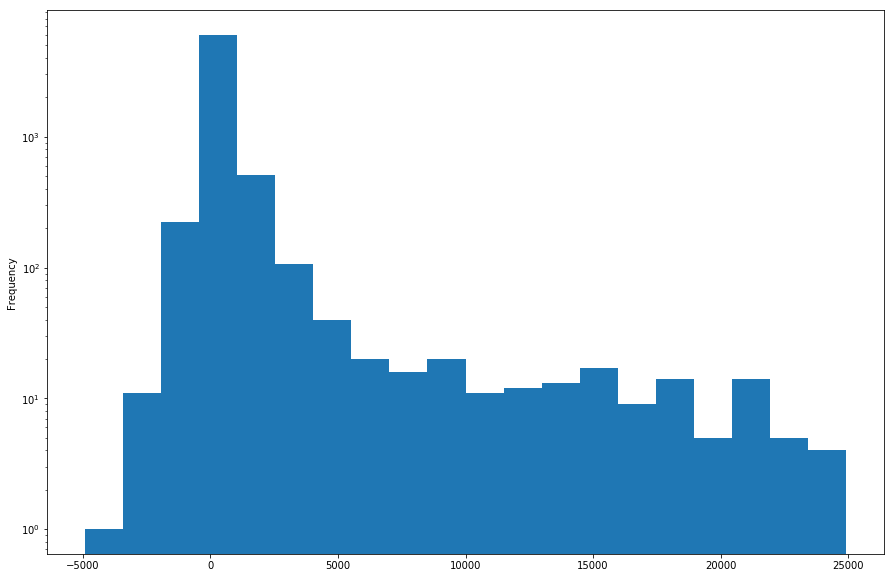

In [11]:
means['ALL'].plot(kind='hist', bins=20, logy=True, figsize=(15,10))

I need a measure of the correlation between a gene and the cancer type in order to identify the genes that are most highly correlated with each cancer type. To generate an estimate of the correlation, I can calculate the difference in the means between the AML samples and the ALL samples for each gene:

$$ \mu_{ALL} - \mu_{AML} $$

I also need to account for the variation of gene expression within each cancer type - to do this, I can calculate the difference in the means relative to the standard deviation for each cancer type:

$$ (\mu_{ALL} - \mu_{AML}) / (\sigma_{ALL} + \sigma_{AML}) $$

cancer                   ALL         AML     ALL:AML
A28102_at   mean  258.555556  316.090909  -57.535354
            std   203.127723  126.132830  329.260553
AB000114_at mean   40.296296    6.090909   34.205387
            std    57.974673   31.007917   88.982590
AB000115_at mean  311.851852  319.090909   -7.239057
             mean_diff     std_sum  correlation
A28102_at   -57.535354  329.260553    -0.174741
AB000114_at  34.205387   88.982590     0.384405
AB000115_at  -7.239057  808.988630    -0.008948
AB000220_at  -6.037037   94.399310    -0.063952
AB000409_at -28.861953  401.672632    -0.071854
(7069, 3)


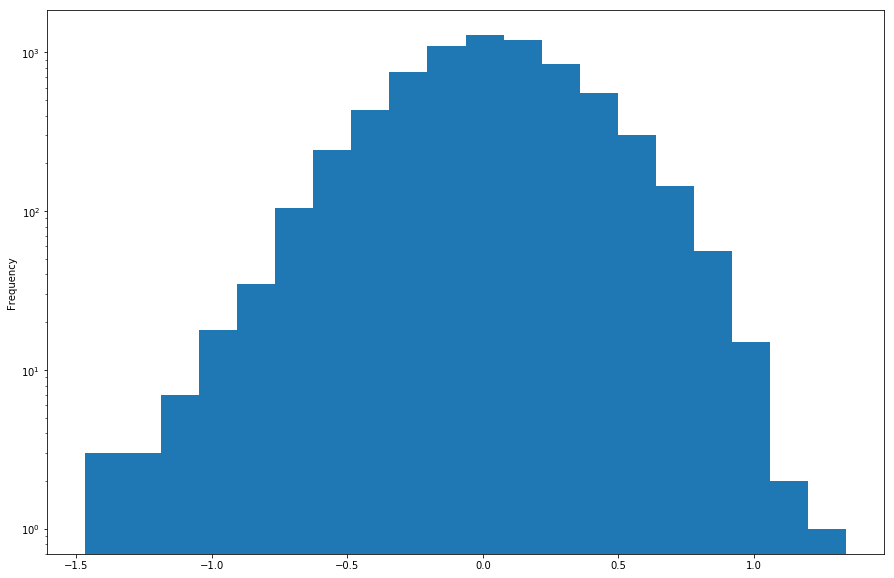

In [12]:
# Remove outlier datapoint before calculating correlation values
df = df.drop(['HG2887-HT3031_at'], axis=0)


correlation = df.loc[(slice(None), slice('mean','std')), :]

# Calculate the difference of ALL mean to AML mean for all genes
correlation.loc[(slice(None), 'mean'), 'ALL:AML'] = (correlation['ALL'] - correlation['AML'])
correlation.loc[(slice(None), 'std'), 'ALL:AML'] = (correlation['ALL'] + correlation['AML'])
print(correlation.head())


mean_diff = correlation.loc[(slice(None), 'mean'), 'ALL:AML']
mean_diff = mean_diff.reset_index(level=1)
mean_diff.drop(columns='level_1', inplace=True)
std_sum = correlation.loc[(slice(None), 'std'), 'ALL:AML']
std_sum = std_sum.reset_index(level=1)
std_sum.drop(columns='level_1', inplace=True)

df_corr = pd.concat([mean_diff, std_sum], axis=1)
df_corr.columns = ['mean_diff', 'std_sum']

# Create a new column of the mean difference (mean_diff) over the standard deviation difference (std_diff) for each gene
df_corr.loc[:, 'correlation'] = (df_corr.mean_diff / df_corr.std_sum)
print(df_corr.head())
print(df_corr.shape)

# Plot a histogram and line plot of the correlation for each gene
df_corr['correlation'].plot(kind='hist', bins=20, logy=True, figsize=(15,10))
plt.show()

In [13]:
# I want to concatenate the previous means dataframe so I can see the ALL_mean and AML_mean for each gene as well
# First, I will recreate the 'means' dataframe from earlier and rename the columns
means_both = df.loc[(slice(None), 'mean'), :]
means_both.reset_index(level=1, inplace=True)
means_both.drop(columns='level_1', inplace=True)
means_both.columns = ['ALL_mean', 'AML_mean']

# Next I will do the same thing to slice out the standard deviations and rename the columns
stdev = df.loc[(slice(None), 'std'), :]
stdev.reset_index(level=1, inplace=True)
stdev.drop(columns='level_1', inplace=True)
stdev.columns = ['ALL_stdev', 'AML_stdev']

# Finally, I will concat the df_corr, means_both, and stdev dataframes together into one dataframe
gene_summary = pd.concat([means_both, stdev, df_corr], axis=1)
gene_summary.sort_values(by=['correlation'], inplace=True)
print(gene_summary.info())

# Write genes_summary to a csv file
gene_summary.to_csv('gene_summary.csv')

<class 'pandas.core.frame.DataFrame'>
Index: 7069 entries, M55150_at to U22376_cds2_s_at
Data columns (total 7 columns):
ALL_mean       7069 non-null float64
AML_mean       7069 non-null float64
ALL_stdev      7069 non-null float64
AML_stdev      7069 non-null float64
mean_diff      7069 non-null float64
std_sum        7069 non-null float64
correlation    7069 non-null float64
dtypes: float64(7)
memory usage: 441.8+ KB
None


In [14]:
top_genes = gene_summary[abs(gene_summary.correlation) >= 0.9]
print(top_genes.shape)
print(top_genes)

(55, 7)
                     ALL_mean      AML_mean    ALL_stdev    AML_stdev  \
M55150_at          810.296296   1836.272727   338.178471   360.886434   
U50136_rna1_at     977.777778   2562.181818   324.689003   789.747785   
X95735_at          349.888889   3023.636364   395.515567  1506.464687   
M16038_at          375.370370   1811.636364   240.297436   953.688238   
M23197_at          175.037037    767.272727    84.092660   411.098307   
M84526_at         -177.407407   3483.000000   176.454234  2896.836067   
Y12670_at          411.148148   1294.454545   212.365198   533.206595   
U82759_at          241.370370    850.727273   239.562124   283.868311   
D49950_at           75.370370    243.909091    54.687327    93.180958   
M27891_at          144.444444   7423.545455   427.020656  6135.518044   
X17042_at         1642.814815   7108.727273  1774.329257  3167.836899   
U12471_cds1_at     152.222222    287.181818    67.401971    58.760222   
U46751_at         1512.148148   5291.272727

Index(['X63469_at', 'D38073_at', 'U29175_at', 'M91432_at', 'S50223_at',
       'AF009426_at', 'X15949_at', 'X52142_at', 'Z15115_at', 'M28170_at',
       'L47738_at', 'U32944_at', 'M31523_at', 'D26156_s_at', 'U09087_s_at',
       'M31211_s_at', 'L13278_at', 'X74262_at', 'M92287_at', 'U05259_rna1_at',
       'X59417_at', 'U22376_cds2_s_at'],
      dtype='object')


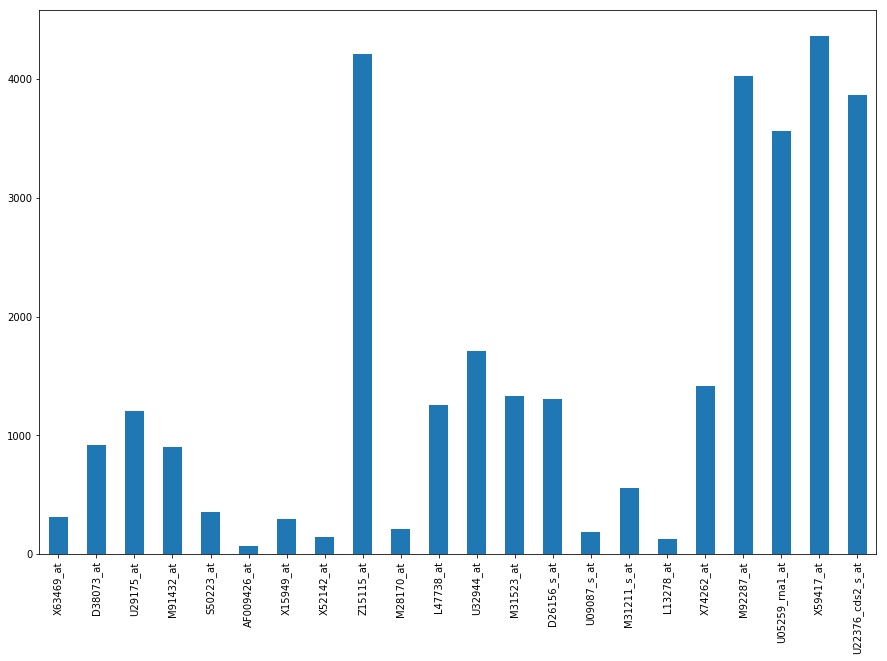

Index(['M55150_at', 'U50136_rna1_at', 'X95735_at', 'M16038_at', 'M23197_at',
       'M84526_at', 'Y12670_at', 'U82759_at', 'D49950_at', 'M27891_at',
       'X17042_at', 'U12471_cds1_at', 'U46751_at', 'Y00787_s_at', 'L08246_at',
       'M80254_at', 'M62762_at', 'M81933_at', 'M96326_rna1_at',
       'M28130_rna1_s_at', 'M63138_at', 'M11147_at', 'M57710_at',
       'M81695_s_at', 'X85116_rna1_s_at', 'M19045_f_at', 'X04085_rna1_at',
       'M21551_rna1_at', 'M69043_at', 'X14008_rna1_f_at', 'M83652_s_at',
       'J03801_f_at', 'X58431_rna2_s_at'],
      dtype='object')


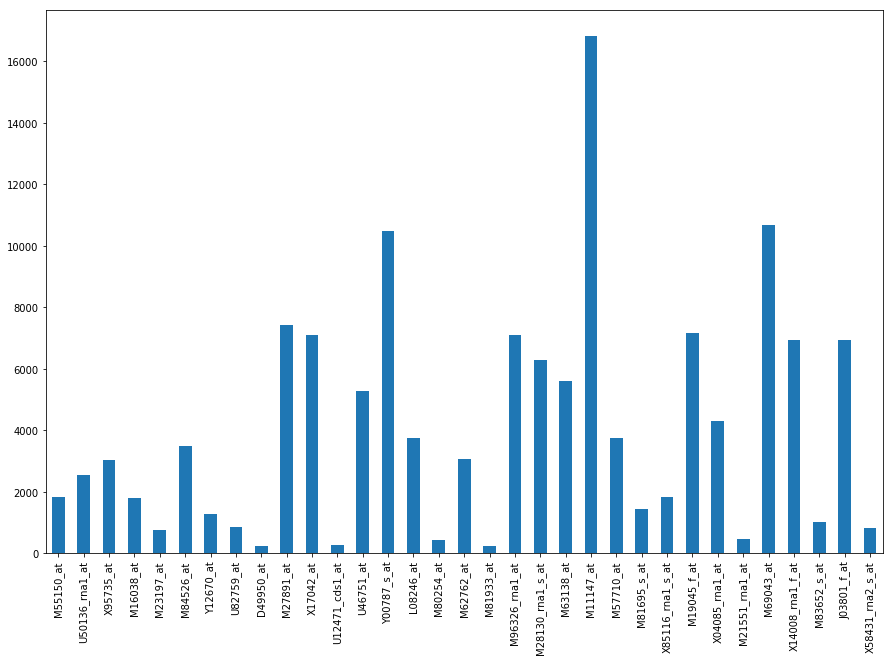

In [15]:
top_genes_ALL = top_genes[top_genes.correlation >= 0.9]
top_genes_AML = top_genes[top_genes.correlation <= 0.9]
print(top_genes_ALL.index)
top_genes_ALL['ALL_mean'].plot(kind='bar', figsize=(15,10))
plt.show()
print(top_genes_AML.index)
top_genes_AML['AML_mean'].plot(kind='bar', figsize=(15,10))
plt.show()